Langchain 在实现与外部数据对话的功能时需要经历下面的5个阶段，它们分别是：Document Loading->Splitting->Storage->Retrieval->Output，如下图所示：

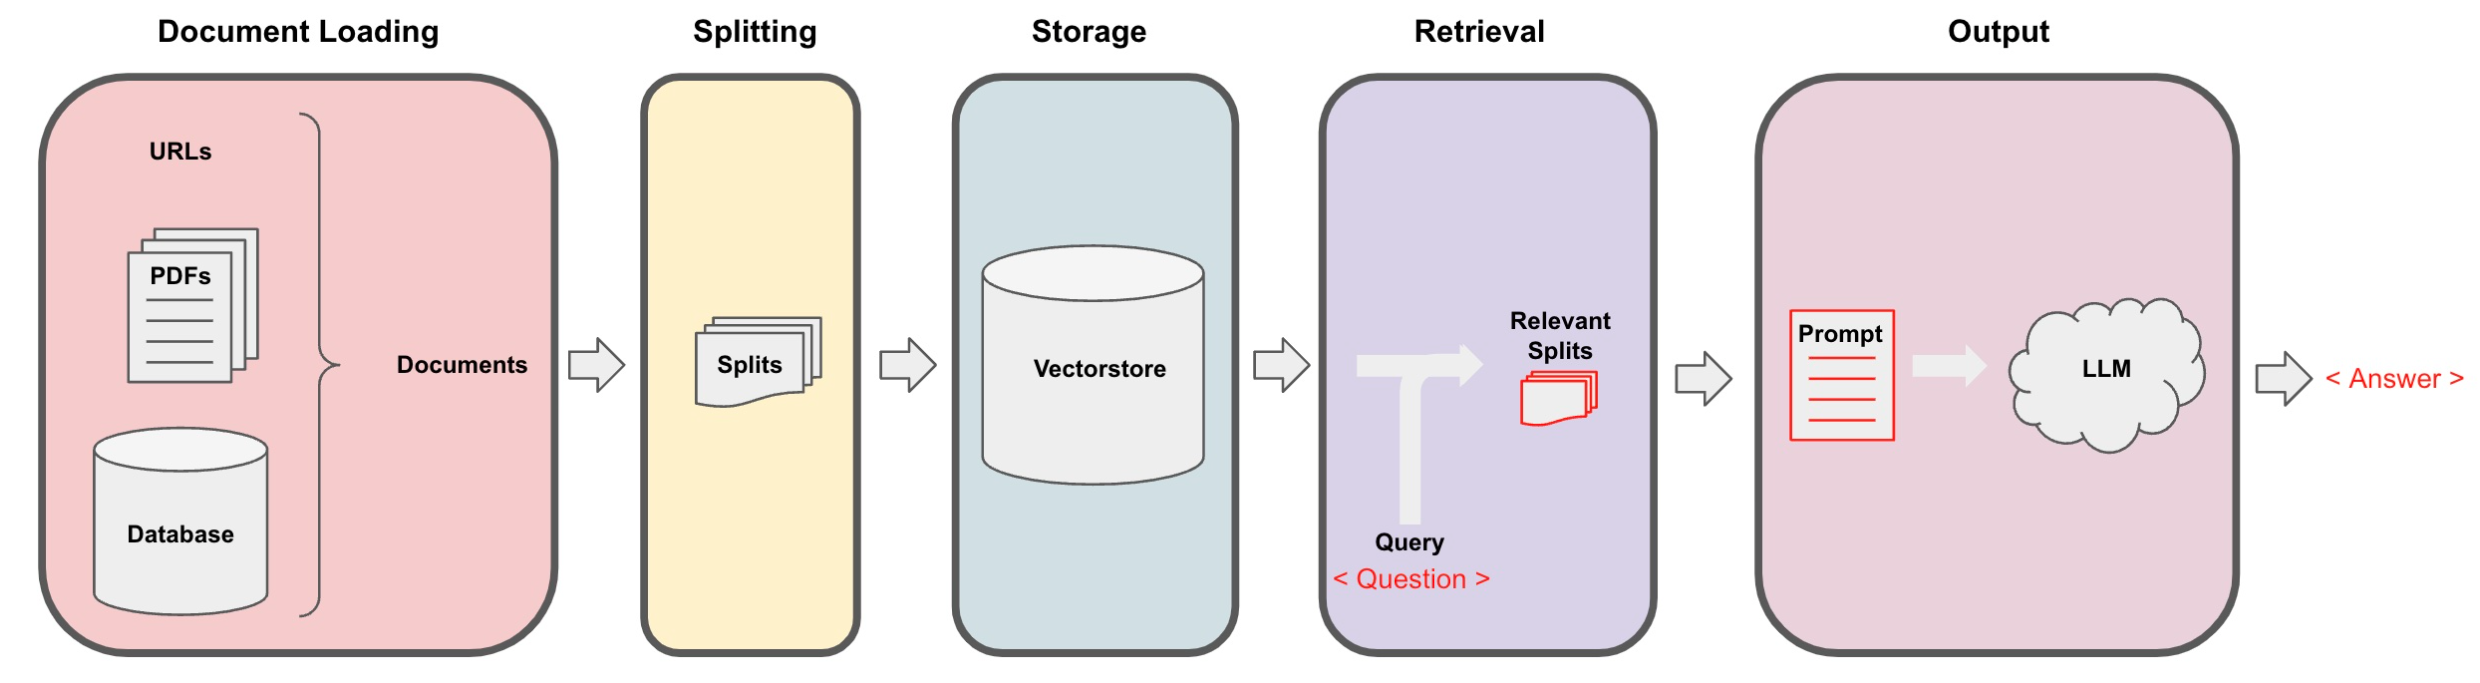

已完成了整个存储和获取，获取到分割的检索答案后，将它们传递给语言模型。

## 一、加载向量数据库


In [2]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

print(vectordb._collection.count())

18


In [4]:
question = "这节课的主要话题是什么"
docs = vectordb.similarity_search(question,k=3)
len(docs)
print(docs)

[Document(metadata={'source': 'docs\\Matplotlib初相识.md'}, page_content='```{code-cell} ipython3\n# step1 准备数据\nx = np.linspace(0, 2, 100)\ny = x**2\n\n# step2 设置绘图样式，这一模块的扩展参考第五章进一步学习，这一步不是必须的，样式也可以在绘制图像是进行设置\nmpl.rc(\'lines\', linewidth=4, linestyle=\'-.\')\n\n# step3 定义布局， 这一模块的扩展参考第三章进一步学习\nfig, ax = plt.subplots()\n\n# step4 绘制图像， 这一模块的扩展参考第二章进一步学习\nax.plot(x, y, label=\'linear\')\n\n# step5 添加标签，文字和图例，这一模块的扩展参考第四章进一步学习\nax.set_xlabel(\'x label\')\nax.set_ylabel(\'y label\')\nax.set_title("Simple Plot")\nax.legend() ;\n```\n\n\u200b\n\n## 思考题\n\n- 请思考两种绘图模式的优缺点和各自适合的使用场景\n- 在第五节绘图模板中我们是以 OO 模式作为例子展示的，请思考并写一个 pyplot 绘图模式的简单模板'), Document(metadata={'source': 'docs\\Matplotlib初相识.md'}, page_content='---\njupytext:\n  text_representation:\n    format_name: myst\nkernelspec:\n  display_name: Python 3\n  name: python3\n---\n\n# 第一回：Matplotlib 初相识\n\n## 一、认识 matplotlib\n\nMatplotlib 是一个 Python 2D 绘图库，能够以多种硬拷贝格式和跨平台的交互式环境生成出版物质量的图形，用来绘制各种静态，动态，交互式的图表。\n\nMatplotlib 可用于 Python 脚本，Python 和 IP

## 二、构造检索式问答链

In [5]:
# 使用 ChatGPT3.5，温度设置为0
from langchain.chat_models import ChatOpenAI
# from langchain_openai import ChatOpenAI
# 导入检索式问答链
from langchain.chains import RetrievalQA

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# 声明一个检索式问答链
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

# 可以以该方式进行检索问答
question = "这节课的主要话题是什么"
result = qa_chain({"query": question})

print(result["result"])


d:\Anaconda3\envs\.venv\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
d:\Anaconda3\envs\.venv\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


这节课的主要话题是 Matplotlib 的初相识，介绍了 Matplotlib 的基本概念、一个最简单的绘图例子、Figure 的组成、两种绘图接口以及通用绘图模板。


## 三、深入探究检索式问答链
在获取与问题相关的文档后，我们需要将文档和原始问题一起输入语言模型，生成回答。默认是合并所有文档，一次性输入模型。但存在上下文长度限制的问题，若相关文档量大，难以一次将全部输入模型。针对这一问题，本章将介绍 MapReduce 、Refine 和 MapRerank 三种策略。

* MapReduce 通过多轮检索与问答实现长文档处理
* Refine 让模型主动请求信息
* MapRerank 则通过问答质量调整文档顺序。

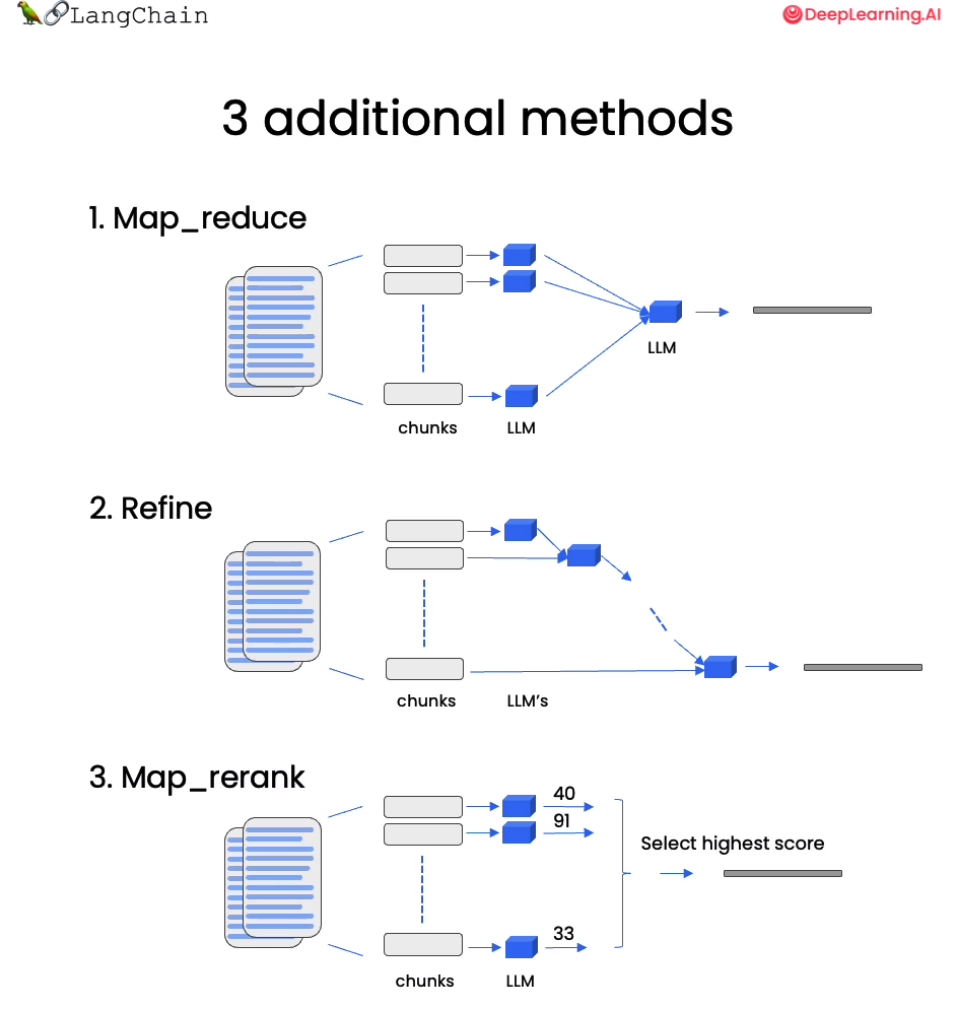

三种策略各有优劣 MapReduce 分批处理长文档，Refine 实现可交互问答，MapRerank 优化信息顺序，掌握这些技巧，可以应对语言模型的上下文限制，解决长文档问答困难，提升问答覆盖面。

3.1 基于模板的检索式问答链 

In [6]:
# 中文版
from langchain.prompts import PromptTemplate

# Build prompt
template = """使用以下上下文片段来回答最后的问题。如果你不知道答案，只需说不知道，不要试图编造答案。答案最多使用三个句子。尽量简明扼要地回答。在回答的最后一定要说"感谢您的提问！"
{context}
问题：{question}
有用的回答："""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [7]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "这门课会学习 Python 吗"
result = qa_chain({"query": question})
print(result["result"])

不知道，这篇文章主要介绍了 Matplotlib 的基本知识和绘图模板，没有提到学习 Python。感谢您的提问！


In [8]:
# 查看其检索到的源文档：
print(result["source_documents"][0])

page_content='```{code-cell} ipython3
# step1 准备数据
x = np.linspace(0, 2, 100)
y = x**2

# step2 设置绘图样式，这一模块的扩展参考第五章进一步学习，这一步不是必须的，样式也可以在绘制图像是进行设置
mpl.rc('lines', linewidth=4, linestyle='-.')

# step3 定义布局， 这一模块的扩展参考第三章进一步学习
fig, ax = plt.subplots()

# step4 绘制图像， 这一模块的扩展参考第二章进一步学习
ax.plot(x, y, label='linear')

# step5 添加标签，文字和图例，这一模块的扩展参考第四章进一步学习
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.set_title("Simple Plot")
ax.legend() ;
```

​

## 思考题

- 请思考两种绘图模式的优缺点和各自适合的使用场景
- 在第五节绘图模板中我们是以 OO 模式作为例子展示的，请思考并写一个 pyplot 绘图模式的简单模板' metadata={'source': 'docs\\Matplotlib初相识.md'}


3.2 基于 MapReduce 的检索式问答链